In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

In [2]:
import pandas as pd
import numpy as np
from src.models import fit_ols, extract_coefficients
from src.config import DATA_PROCESSED

## Análise da Regressão Linear sem logaritimizar

In [3]:
df = pd.read_csv(DATA_PROCESSED / "base_analitica.csv", parse_dates=["date"])

y = "demanda_energia"

X = [
    "tarifa_energia_real",
    "pib_real",
    "importacoes_petroleo",
    "d_2001",
    "d_2006",
    "d_2008",
    "d_2020"
]

results = fit_ols(df, y, X)

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        demanda_energia   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     282.7
Date:                Sat, 17 Jan 2026   Prob (F-statistic):          3.95e-137
Time:                        17:22:17   Log-Likelihood:                -5182.5
No. Observations:                 346   AIC:                         1.038e+04
Df Residuals:                     338   BIC:                         1.041e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.135e+06 

## Indícios

- Alta probabilidade do modelo ter um alto grau de Multicolinearidade conforme sugerido na nota o que altera drasticamente os coeficientes das variáveis independentes
- Alta probabilidade de ter autocorrelação dos resíduos, pelo baixo valor do "d" de Durbin Watson 
- Provavel Heterocedasticidade dos Resíduos


In [4]:
df_log = df.copy()
df_log["ln_demanda"] = np.log(df_log["demanda_energia"])
df_log["ln_tarifa"] = np.log(df_log["tarifa_energia_real"]) 
df_log["ln_pib"] = np.log(df_log["pib_real"]) 
df_log["ln_importacoes"] = np.log(df_log["importacoes_petroleo"])

## Regressão Linear Múltipla Log
- Log das variáveis

In [5]:
y_log = "ln_demanda"

X_log = [
    "ln_tarifa",
    "ln_pib",
    "ln_importacoes",
    "d_2001",
    "d_2006",
    "d_2008",
    "d_2020"
]

results = fit_ols(df_log, y_log, X_log)

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             ln_demanda   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     408.1
Date:                Sat, 17 Jan 2026   Prob (F-statistic):          1.20e-160
Time:                        17:22:18   Log-Likelihood:                 534.53
No. Observations:                 346   AIC:                            -1053.
Df Residuals:                     338   BIC:                            -1022.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             11.9793      0.257     46.

## Análise gráfica dos valores ajustados

<Axes: >

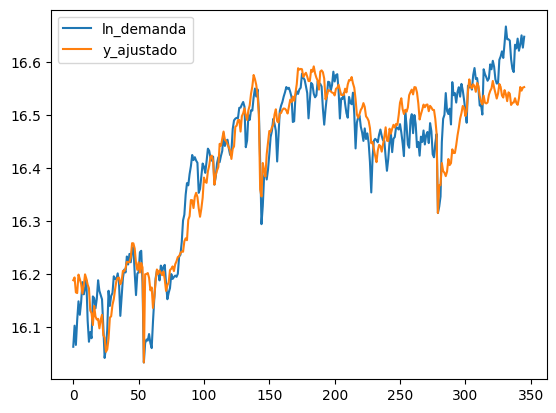

In [6]:
from src.models import fitted_values

df_log["y_ajustado"] = fitted_values(results)
df_log[["ln_demanda", "y_ajustado"]].plot()

In [7]:
from src.models import residuals

df_log["resid"] = residuals(results)

## Análise das Premissas do Método dos MQO
- Normalidade
- Heterocedasticidade
- Autocorrelação
- Multicolinearidade

In [8]:

from src.diagnostics import (
    run_all_diagnostics,
    calculate_vif
)

diagnostics_df = run_all_diagnostics(results)
vif_df = calculate_vif(results)

diagnostics_df


,test,statistic,p_value,skewness,kurtosis,f_stat,f_p_value,lags,lm_stat,lm_p_value,resultado
0,Jarque-Bera,2.718699,2.568278e-01,0.217948,0.032618,NaN,NaN,NaN,NaN,NaN,Dados com normalidade
1,Durbin-Watson,0.311561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Resultado indefinido
2,Breusch-Godfrey,242.310210,1.233066e-54,NaN,NaN,787.527306,3.402522e-90,1.0,NaN,NaN,Com autocorrelação
3,Breusch-Pagan,NaN,NaN,NaN,NaN,2.312173,2.580243e-02,NaN,15.811170,0.026899,Dados Heterocedásticos
4,White,NaN,NaN,NaN,NaN,3.620254,1.314546e-05,NaN,45.945155,0.000029,Dados Heterocedásticos


In [9]:
vif_df

,variavel,vif,resultado
0,ln_tarifa,2335.043222,Multicolinearidade severa
1,ln_pib,2303.641553,Multicolinearidade severa
2,ln_importacoes,71.452400,Multicolinearidade severa
3,d_2001,1.006560,Sem multicolinearidade
4,d_2006,1.012214,Sem multicolinearidade
5,d_2008,1.009758,Sem multicolinearidade
6,d_2020,1.008121,Sem multicolinearidade


## O Modelo está especificado de forma incorreta pois: 
- Quebra a Hipótese de Autocorrelação
- Quebra a Hipótese de Homocedasticidade dos resíduos (facilmente ajustada com correção de erros robustos)
- Quebra a hipótese de Multicolinearidade
- Apenas a hipótese de normalidade é atendida

## O que Fazer para resolver esses problemas de especificação?

- Vou Diferenciar as variáveis (dependente e independente, exceto dummies obviamente) para ajustar a Muticolinearidade e Autocorrelação
- Utilizar erro robusto padrão para eliminar heterocedasticidade 

In [10]:
df_log["d_ln_demanda"] = df_log["ln_demanda"].diff()
df_log["d_ln_tarifa"] = df_log["ln_tarifa"].diff()
df_log["d_ln_pib"] = df_log["ln_pib"].diff()
df_log["d_ln_importacoes"] = df_log["ln_importacoes"].diff()

df_diff = df_log.dropna().copy()

## Meu Modelo agora: 
- ΔlnDt​=β1​ΔlnPt​+β2​ΔlnYt​+β3​ΔlnPBSt​+γ1​D2001t​+γ2​D2006t​+γ3​D2008t​+γ4​D2020t​+ut​

In [11]:
from src.models import fit_ols

results = fit_ols(
    df=df_diff,
    y="d_ln_demanda",
    X=[
        "d_ln_tarifa",
        "d_ln_pib",
        "d_ln_importacoes",
        "d_2001",
        "d_2006",
        "d_2008",
        "d_2020"
    ]
)

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:           d_ln_demanda   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     28.96
Date:                Sat, 17 Jan 2026   Prob (F-statistic):           3.48e-31
Time:                        17:22:19   Log-Likelihood:                 792.34
No. Observations:                 345   AIC:                            -1569.
Df Residuals:                     337   BIC:                            -1538.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0027      0.001  

In [12]:
diagnostics_df = run_all_diagnostics(results)
vif_df = calculate_vif(results)

diagnostics_df

,test,statistic,p_value,skewness,kurtosis,f_stat,f_p_value,lags,lm_stat,lm_p_value,resultado
0,Jarque-Bera,6.440853,0.039938,0.288492,0.366198,NaN,NaN,NaN,NaN,NaN,Dados sem normalidade
1,Durbin-Watson,2.188247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Resultado indefinido
2,Breusch-Godfrey,3.763742,0.052375,NaN,NaN,3.705987,0.055061,1.0,NaN,NaN,Sem autocorrelação
3,Breusch-Pagan,NaN,NaN,NaN,NaN,1.373615,0.215496,NaN,9.570495,0.214247,Dados Heterocedásticos
4,White,NaN,NaN,NaN,NaN,3.352770,0.000046,NaN,42.961563,0.000087,Dados Heterocedásticos


In [13]:
vif_df

,variavel,vif,resultado
0,d_ln_tarifa,1.015763,Sem multicolinearidade
1,d_ln_pib,1.055051,Sem multicolinearidade
2,d_ln_importacoes,1.071092,Sem multicolinearidade
3,d_2001,1.004710,Sem multicolinearidade
4,d_2006,1.014417,Sem multicolinearidade
5,d_2008,1.013039,Sem multicolinearidade
6,d_2020,1.078516,Sem multicolinearidade


In [14]:
import importlib
import src.models as models

# 2. Força recarregamento do arquivo
importlib.reload(models)

from src.models import apply_robust_errors

results_robust = apply_robust_errors(results, cov_type="HC1") #Erros robustos de White
print(results_robust.summary())


                            OLS Regression Results                            
Dep. Variable:           d_ln_demanda   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     1715.
Date:                Sat, 17 Jan 2026   Prob (F-statistic):          3.43e-237
Time:                        17:22:19   Log-Likelihood:                 792.34
No. Observations:                 345   AIC:                            -1569.
Df Residuals:                     337   BIC:                            -1538.
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0027      0.001  

c:\Users\Almyr Godoy\Desktop\Trabalhos e Análise de Dados\1.0 Projetos GITHUB\energy_demand_brazil\venv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 5
  warnings.warn('covariance of constraints does not have full '


<Axes: >

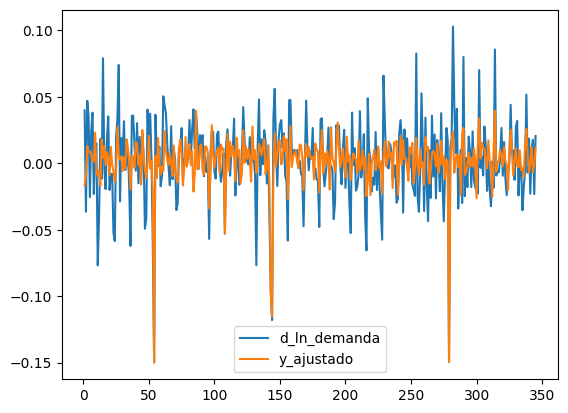

In [15]:
from src.models import fitted_values

df_diff["y_ajustado"] = fitted_values(results)
df_diff[["d_ln_demanda", "y_ajustado"]].plot()

## Modelo Final pelo Método dos Mínimos Quadrados Ordinários


- Assume-se Normalidade dos Dados pela Teoria Econômica (Pela quantidade de Observações/tamanho da amostra)
- Heterocedasticidade ajustada pelos Erros Robustos Padrão de White
- Sem Autocorrelação
- Sem Multicolinearidade 

# Resultados e Análise do Modelo

- É um modelo de curto prazo, em primeiras diferenças logarítmicas
- Elasticidades de curto prazo
- Redução de problemas de não estacionariedade
- Interpretação direta em termos percentuais

### Qualidade do ajuste do modelo
- R2 ajustado = 0,363 (abaixo do esperado)
- Estatística F (Prob = 3.43e-237) - modelo é globalmente válido pois rejeita-se a hipótese de que todos os coeficientes sejam conjuntamente nulos

O modelo explica aproximadamente 36% da variação de curto prazo da demanda de energia elétrica industrial, desempenho satisfatório para séries macroeconômicas em diferenças, porém, sugere-se incrementar oura variável como bem substituto pois o índice dos preços de importação dos derivados do petróleo não se adequaram bem ao modelo.

### Interpretação Econômica dos Coeficientes

Preço da energia elétrica (d_ln_tarifa)
𝛽 = − 0.1143 (𝑝 = 0.005)

Elasticidade-preço negativa e estatisticamente significativa

Um aumento de 1% na tarifa reduz a demanda em 0,11% no curto prazo

📌 Leitura econômica:

Demanda inelástica ao preço no curto prazo

Coerente com a literatura: energia elétrica é insumo essencial

Ajustes tecnológicos e substituição ocorrem lentamente